<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/billyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
import pickle
df = pickle.load( open( "../data/df_words_target.pkl", "rb" ) )

In [5]:
# Convert to list
data = df.transcripts.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[:2])

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

In [15]:
tm = trigram_mod[bigram_mod[data_words[0]]]

In [20]:
tm = df['transcripts'].str.cat(sep=', ')

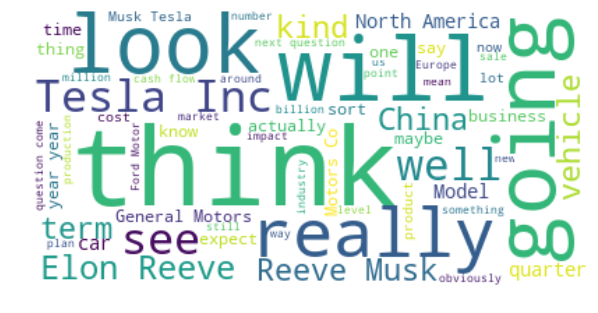

In [23]:
from os import path
from wordcloud import WordCloud

text1 = tm
# Generate a word cloud image
wordcloud1 = WordCloud(max_words=60,background_color="white").generate(text1)
# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))

import matplotlib.pyplot as plt
plt.imshow(wordcloud1, interpolation='bilinear') 

plt.axis("off")
plt.show()

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:10])

[['general_motor', 'company', 'gm', 'ceo', 'mary', 'barra', 'result', 'earning', 'call_transcript', 'company', 'gm', 'earnings_summary', 'press_release', 'slides_ep', 'beat', 'revenue', 'miss', 'subscriber', 'earn', 'call', 'audio', 'general_motor', 'company', 'earning', 'conference_call', 'april', 'company', 'participant', 'rocky_gupta', 'treasurer', 'vice_president', 'investor_relation', 'mary', 'barra', 'chairman_chief', 'executive_officer', 'dhivya_suryadevara', 'executive', 'vice_president', 'chief', 'financial', 'officer', 'conference_call', 'participant', 'wolfe_research', 'itay_michaeli', 'citi', 'john_murphy', 'bank', 'america_merrill', 'lynch', 'adam_jonas', 'morgan_stanley', 'joseph_spak', 'market', 'david_tamberrino', 'goldman_sachs', 'ryan_brinkman', 'brian_johnson', 'barclays_capital', 'colin_langan', 'ubs', 'operator_lady', 'gentleman', 'welcome', 'general_motor', 'company', 'first', 'quarter', 'earning', 'conference_call', 'opening_remarks', 'participant', 'listen', 'mo

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:5])

[[(0, 1), (1, 8), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 9), (8, 1), (9, 24), (10, 5), (11, 1), (12, 5), (13, 6), (14, 4), (15, 7), (16, 4), (17, 3), (18, 1), (19, 9), (20, 1), (21, 1), (22, 1), (23, 1), (24, 5), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1), (30, 1), (31, 2), (32, 3), (33, 1), (34, 2), (35, 2), (36, 8), (37, 15), (38, 1), (39, 1), (40, 2), (41, 2), (42, 1), (43, 6), (44, 2), (45, 4), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 5), (52, 1), (53, 3), (54, 1), (55, 2), (56, 2), (57, 1), (58, 3), (59, 3), (60, 4), (61, 2), (62, 1), (63, 1), (64, 2), (65, 2), (66, 1), (67, 2), (68, 1), (69, 3), (70, 2), (71, 1), (72, 5), (73, 6), (74, 3), (75, 1), (76, 1), (77, 1), (78, 2), (79, 2), (80, 1), (81, 2), (82, 4), (83, 2), (84, 2), (85, 1), (86, 11), (87, 1), (88, 3), (89, 3), (90, 1), (91, 1), (92, 2), (93, 2), (94, 18), (95, 1), (96, 4), (97, 1), (98, 6), (99, 2), (100, 1), (101, 25), (102, 1), (103, 1), (104, 3), (105, 6), (106, 8), (107, 3), (108, 1), (109, 2), (11

In [17]:
id2word[0]

'ability'

In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[1:10]]

[[('able', 10),
  ('achieve', 1),
  ('action', 1),
  ('actually', 21),
  ('adam', 1),
  ('adam_jonas', 7),
  ('add', 7),
  ('additional', 3),
  ('address', 1),
  ('adjust', 2),
  ('adjustment', 9),
  ('advantage', 1),
  ('aggressive', 1),
  ('ago', 6),
  ('agree', 3),
  ('agreement', 1),
  ('almost', 4),
  ('already', 4),
  ('also', 18),
  ('always', 2),
  ('amount', 3),
  ('announce', 5),
  ('answer_session', 1),
  ('anticipate', 5),
  ('anyone_else', 1),
  ('anything', 1),
  ('apply', 2),
  ('appreciate', 1),
  ('approach', 1),
  ('appropriate', 1),
  ('approximately', 1),
  ('april', 3),
  ('area', 1),
  ('ask', 5),
  ('asset', 2),
  ('assumption', 2),
  ('audio', 1),
  ('automotive', 6),
  ('available', 1),
  ('average', 1),
  ('back', 9),
  ('balance', 7),
  ('base', 6),
  ('basically', 3),
  ('basis', 2),
  ('battery', 7),
  ('begin', 3),
  ('believe', 5),
  ('benefit', 2),
  ('better', 4),
  ('big', 7),
  ('bill', 1),
  ('bit', 2),
  ('bring', 1),
  ('broad', 1),
  ('build', 8),

In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"year" + 0.001*"question" + 0.001*"think" + 0.001*"quarter" + '
  '0.001*"go" + 0.001*"thank" + 0.001*"co" + 0.001*"tesla" + 0.001*"would" + '
  '0.001*"inc"'),
 (1,
  '0.005*"year" + 0.004*"think" + 0.003*"co" + 0.003*"general_motor" + '
  '0.003*"look" + 0.003*"s" + 0.003*"quarter" + 0.002*"go" + 0.002*"expect" + '
  '0.002*"cost"'),
 (2,
  '0.004*"year" + 0.004*"think" + 0.003*"go" + 0.002*"question" + 0.002*"get" '
  '+ 0.002*"look" + 0.002*"would" + 0.002*"model" + 0.002*"quarter" + '
  '0.002*"s"'),
 (3,
  '0.003*"year" + 0.002*"quarter" + 0.002*"think" + 0.001*"go" + 0.001*"would" '
  '+ 0.001*"see" + 0.001*"thank" + 0.001*"s" + 0.001*"well" + 0.001*"inc"'),
 (4,
  '0.043*"tesla" + 0.041*"inc" + 0.020*"elon" + 0.018*"reeve_musk" + 0.014*"s" '
  '+ 0.013*"think" + 0.012*"go" + 0.010*"really" + 0.010*"be" + 0.010*"car"'),
 (5,
  '0.004*"s" + 0.004*"year" + 0.004*"think" + 0.004*"co" + '
  '0.003*"general_motor" + 0.003*"question" + 0.003*"go" + 0.003*"would" + '
  '0

In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.977977276635225

Coherence Score:  0.3526851286121268


In [ ]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis